# cosの推定(LSTM 25ポイントを入れて次の値を予測)

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

#GPUの仕様に関する設定
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(
        visible_device_list = "1",
        allow_growth = True,
        per_process_gpu_memory_fraction = 0.3))
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [2]:
def myplot(y,ylabel='',title=''):
    plt.ylabel(ylabel)
    plt.plot(y, linestyle='--', alpha=0.5)

## cos波データの作成

In [3]:
n_data = 2000
n_test = 200
noize = 0.1 * np.random.uniform(low=-1.0, high=1.0, size=n_data)
data = np.cos(2.0*np.pi*np.arange(0,n_data)/100.0) + noize

In [4]:
x_train = [data[i:i+25] for i in range(n_data - 25 - n_test)]
x_train = np.array(x_train).reshape(len(x_train),25,1)
x_test = [data[i:i+25] for i in range(n_data - n_test, n_data - 25)]
x_test = np.array(x_test).reshape(len(x_test),25,1)
y_train = [data[i+25] for i in range(n_data - 25 - n_test)]
y_train = np.array(y_train).reshape(len(y_train),1)
y_test = [data[i+25] for i in range(n_data - n_test, n_data -25)]
y_test = np.array(y_test).reshape(len(y_test),1)

## モデルの構築(25 - 20 -1)と学習

In [5]:
model = Sequential()
model.add(LSTM(20, kernel_initializer = 'he_normal', input_shape=(25,1), activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,kernel_initializer = 'he_normal', activation='linear'))

model.compile(loss='mean_squared_error', optimizer = 'adam')
model.summary()
model.fit(x_train, y_train, epochs=100, batch_size = 50, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Train on 1597 samples, validate on 178 samples
Epoch 1/100
1597/1597 [==============================] - 2s 1ms/step - loss: 5.9850 - val_loss: 2.5886
Epoch 2/100
1597/1597 [==============================] - 1s 848us/step - loss: 2.1377 - val_loss: 0.5427
Epoch 3/100
1597/1597 [==============================] - 1s 827us/step - loss: 0.9460 - val_loss: 0.1963
Epoch 4/100
1597/1597 [=====================

1597/1597 [==============================] - 1s 827us/step - loss: 0.0268 - val_loss: 0.0055
Epoch 72/100
1597/1597 [==============================] - 1s 828us/step - loss: 0.0267 - val_loss: 0.0054
Epoch 73/100
1597/1597 [==============================] - 1s 837us/step - loss: 0.0233 - val_loss: 0.0053
Epoch 74/100
1597/1597 [==============================] - 1s 821us/step - loss: 0.0257 - val_loss: 0.0082
Epoch 75/100
1597/1597 [==============================] - 1s 843us/step - loss: 0.0242 - val_loss: 0.0070
Epoch 76/100
1597/1597 [==============================] - 1s 848us/step - loss: 0.0255 - val_loss: 0.0051
Epoch 77/100
1597/1597 [==============================] - 1s 862us/step - loss: 0.0240 - val_loss: 0.0053
Epoch 78/100
1597/1597 [==============================] - 1s 830us/step - loss: 0.0249 - val_loss: 0.0052
Epoch 79/100
1597/1597 [==============================] - 1s 854us/step - loss: 0.0233 - val_loss: 0.0050
Epoch 80/100
1597/1597 [==============================] - 1

## モデルの評価

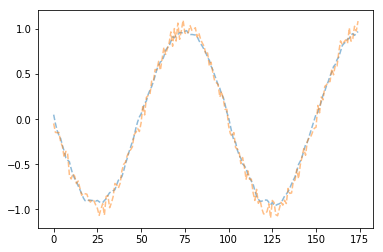

In [6]:
predict = model.predict(x_test)
myplot(predict)
myplot(y_test)

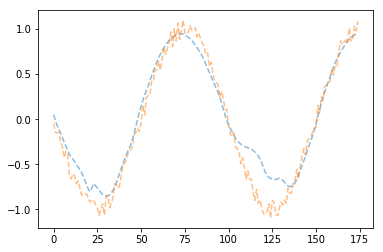

In [7]:
#テストデータの推測(25データから遠い未来の情報)
Z = x_test[:1]
predicted = []
for i in range(n_test - 25):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate((z_.reshape(25,1)[1:],y_),axis=0).reshape(1,25,1)
    
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))
    
myplot(predicted)  
myplot(y_test)

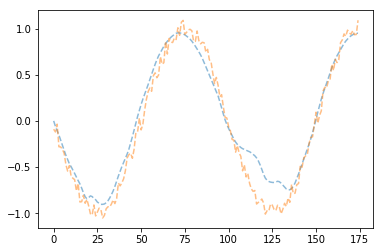

In [8]:
#学習データの推測(25データから遠い未来の情報)
Z = x_train[:1]
predicted = []
for i in range(n_test - 25):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate((z_.reshape(25,1)[1:],y_),axis=0).reshape(1,25,1)
    
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))
    
myplot(predicted)  
myplot(y_train[:n_test-25])

## モデルの保存

In [9]:
model.save('./model/cos_pred_LSTM.hdf5')